In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pymongo import MongoClient
client = MongoClient()

blic = client.blic
b92 = client.b92
n1 = client.n1

In [5]:
blic_comments = list(blic.comments.find())
b92_comments = list(b92.comments.find())
n1_comments = list(n1.comments.find())

blic_reactions = list(blic.reactions.find())
b92_reactions = list(b92.reactions.find())
n1_reactions = list(n1.reactions.find())

all_comments = blic_comments + b92_comments + n1_comments
all_reactions = blic_reactions + b92_reactions + n1_reactions

# Comment dictionary with comment_id's as indices
comments_dict = {}
for comment in all_comments:
    # FIXME: For some reason multiple same comments pop up. 
    comment['reactions'] = []
    comments_dict[comment['comment_id']] = comment
    
# Add the reactions to each comment
for reaction in all_reactions:
    if reaction['comment_id'] not in comments_dict:
        print("Missing comment with ID: %s" % reaction['comment_id'])
    else:
        comments_dict[reaction['comment_id']]['reactions'].append(reaction)    

Missing comment with ID: k19765353
Missing comment with ID: k19765340
Missing comment with ID: k19765405
Missing comment with ID: k19765399


# Broj komentara:

In [6]:
print("Blic: %s" % blic.comments.count())
print("B92: %s" % b92.comments.count())
print("N1: %s" % n1.comments.count())
print("Ukupno: %s" % len(all_comments))

Blic: 3629
B92: 2231
N1: 511
Ukupno: 6371


# Broj korisnika:

In [7]:
print("Blic: %s " % len(blic.reactions.distinct('userid')))
print("B92: %s " % len(b92.reactions.distinct('userid')))
print("N1: %s " % len(n1.reactions.distinct('userid')))

users = set()
for reaction in all_reactions:
    users.add(reaction['userid'])
    
print("Ukupan broj korisnika na sva 3 sajta: %s" % len(users))

Blic: 482 
B92: 140 
N1: 49 
Ukupan broj korisnika na sva 3 sajta: 572


# Broj reakcija po komentaru

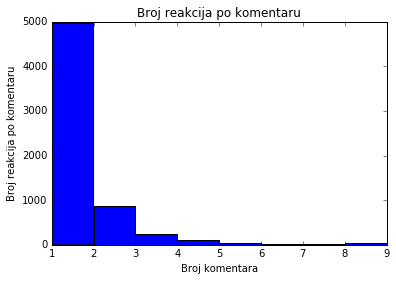

In [8]:
x = [len(x['reactions']) for x in all_comments]

hist, bins = np.histogram(x, bins=500)
n, bins, patches = plt.hist(x, range(1,10))

plt.xlabel('Broj komentara')
plt.ylabel('Broj reakcija po komentaru')
plt.title('Broj reakcija po komentaru')
plt.show()

# Broj reakcija po korisniku

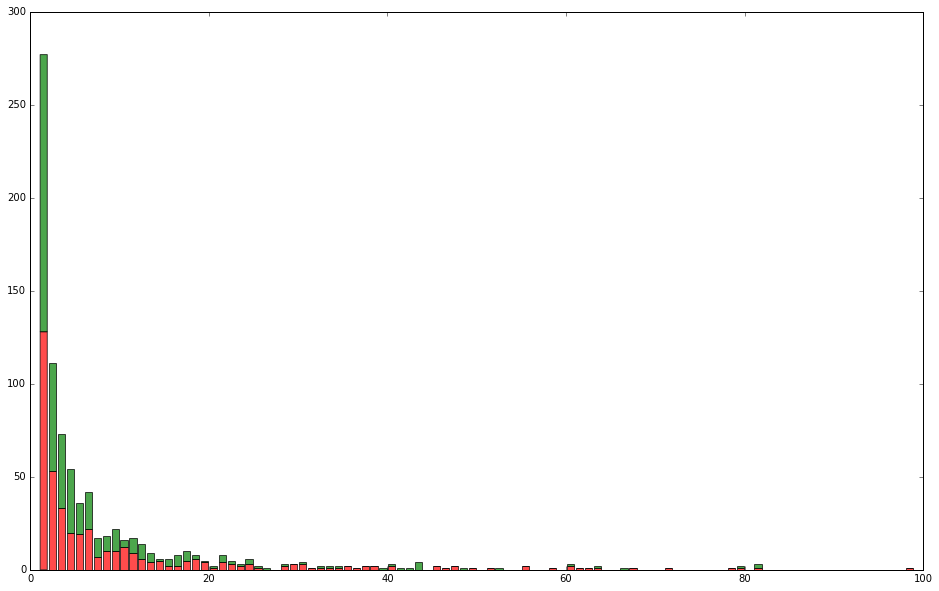

In [9]:
users_dict = {user: {'bot':0, 'not':0} for user in users}

for reaction in all_reactions: 
    user_id = reaction['userid']
    
    if reaction['bot'] == u'false':
        users_dict[user_id]['not'] += 1
    elif reaction['bot'] == u'true':
        users_dict[user_id]['bot'] += 1

bots = list(user['bot'] for user in users_dict.values())
nots = list(user['not'] for user in users_dict.values())

plt.figure(figsize=(16,10))

n, bins, patches = plt.hist([bots, nots], range(1,100), color=['red', 'green'], alpha=0.7, stacked=True)

# plt.xlabel('Broj komentara')
# plt.ylabel('Broj reakcija po komentaru')
# plt.title('Broj reakcija po komentaru')
# plt.show()

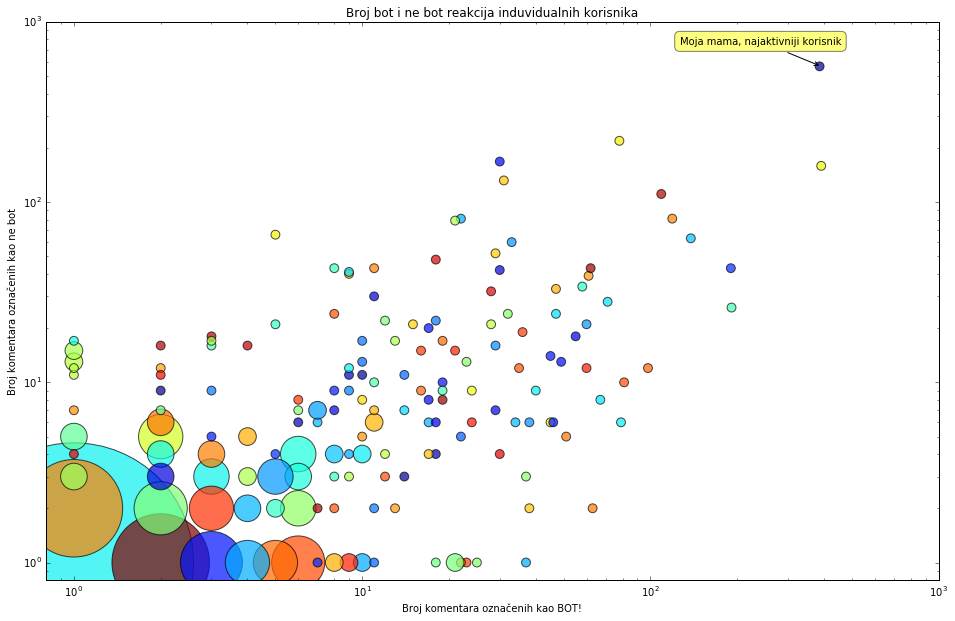

In [10]:
bots = [user['bot'] for user in users_dict.values()]
nots = [user['not'] for user in users_dict.values()]
botnot = [(bots[i], nots[i]) for i in range(len(bots))]
x = []
y = []
area = []

while len(botnot) > 0:
    bn = botnot[0]
    x.append(bn[0]), y.append(bn[1])
    area.append(botnot.count(bn))
    for i in range(botnot.count(bn)):
        botnot.remove(bn)

colors = np.random.rand(len(x))
area = np.array(area)
min_width = np.pi * 5 ** 2
area = (area ** 2) * min_width

plt.figure(figsize=(16,10))
fig = plt.scatter(x, y, s=area, c=colors, alpha=0.7)

# labels
plt.title(u"Broj bot i ne bot reakcija induvidualnih korisnika")
plt.xlabel(u"Broj komentara označenih kao BOT!")
plt.ylabel(u"Broj komentara označenih kao ne bot")

# # log scale
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8, 1000)
plt.xlim(0.8, 1000)

# # Majka
xm = max(bots)
ym = max(nots)
plt.annotate(
    "Moja mama, najaktivniji korisnik", 
    xy = (xm, ym), xytext = (20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

# TreeMap korisnika
# Graf korisnika sa slajderom.
### Node-ovi su korisnici. Korisnici koji su komentarisali na X istih komentara su povezani.

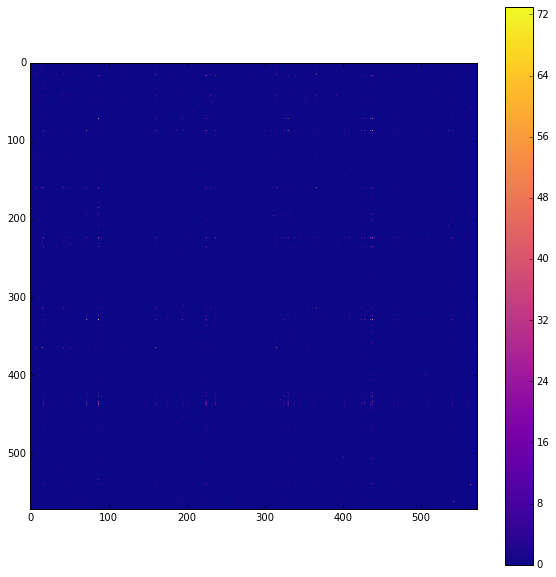

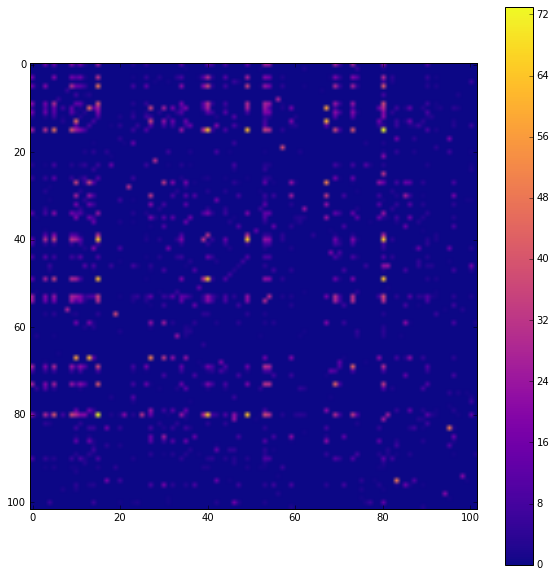

In [116]:
def build_similarity_matrix(all_reactions, min_reactions=5):
    user_reactions = dict()

    # attach reactions to its user
    for reaction in all_reactions:
        id = reaction['userid']
        if id not in user_reactions:
            user_reactions[id] = set([reaction['comment_id']])
        else:
            user_reactions[id].add(reaction['comment_id'])
            
    cleaned_users = dict()
    for user_id in user_reactions:
        if len(user_reactions[user_id]) >= min_reactions:
            cleaned_users[user_id] = user_reactions[user_id]
    
    user_reactions = cleaned_users
    
    # compare reaction sets of every two users
    user_matrix = np.zeros((len(user_reactions), len(user_reactions)))
    for fidx, first_reactions in enumerate(user_reactions.values()):
        for sidx, second_reactions in enumerate(user_reactions.values()):
            overlap = first_reactions.intersection(second_reactions)
            user_matrix[fidx, sidx] = len(overlap)

    # clear the main diagonal
    for i in range(len(user_matrix)):
        user_matrix[i, i] = 0
    
    return user_matrix

    
# Draw the similarity matrix for all users
sm0 = build_similarity_matrix(all_reactions, min_reactions=0)
fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(sm0, cmap="plasma")
plt.colorbar(res)
    
# Draw the similarity matrix for users with at least X reactions
sm20 = build_similarity_matrix(all_reactions, min_reactions=20)
fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(sm20, cmap="plasma")
plt.colorbar(res)

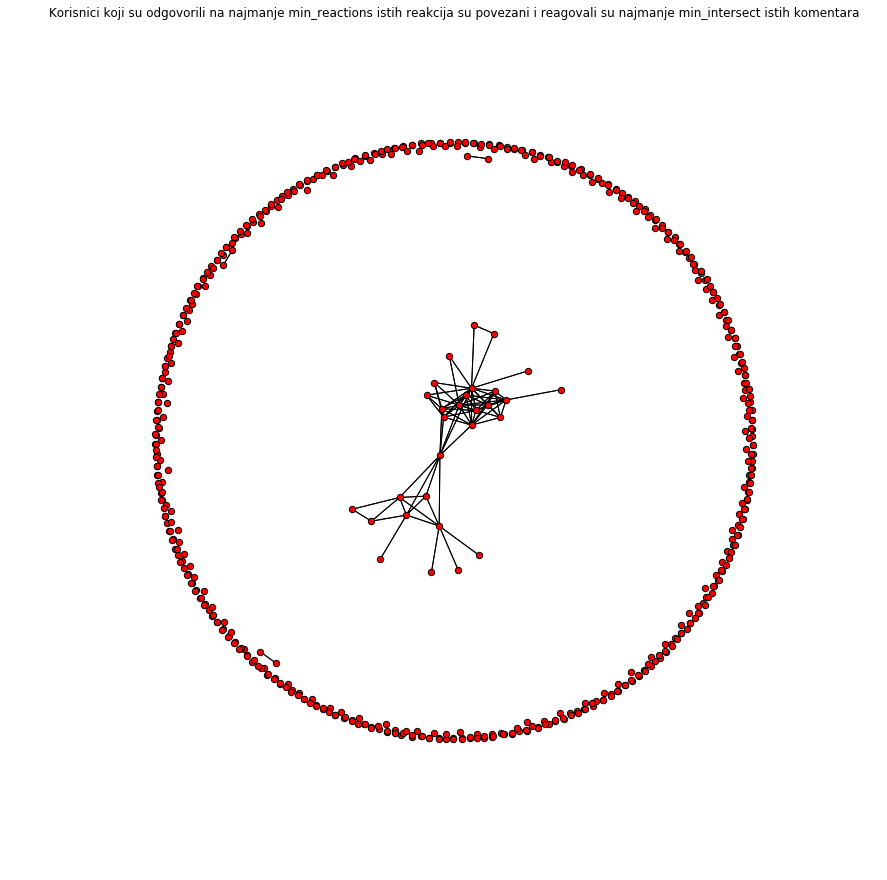

In [149]:
import networkx as nx
import graphviz
from networkx import draw_spring as draw

min_reactions = 0
min_intersect = 20

# a = np.reshape(np.random.random_integers(0,1,size=100),(10,10))
sm = build_similarity_matrix(all_reactions, min_reactions=min_reactions)
edge_matrix = (sm > min_intersect) * 1
G = nx.DiGraph(edge_matrix)

fig, ax = plt.subplots(figsize=(15, 15))
draw(G, show="ipynb", ax=ax,
    weight=sm,
    iterations=2000,
    arrows=False,
    node_size=40,
#     line_widths=1,
    alpha=1)

_ = plt.title("Korisnici koji su odgovorili na najmanje min_reactions istih reakcija su povezani\
 i reagovali su najmanje min_intersect istih komentara")